# Treasure Drop Deep Q Learning Project

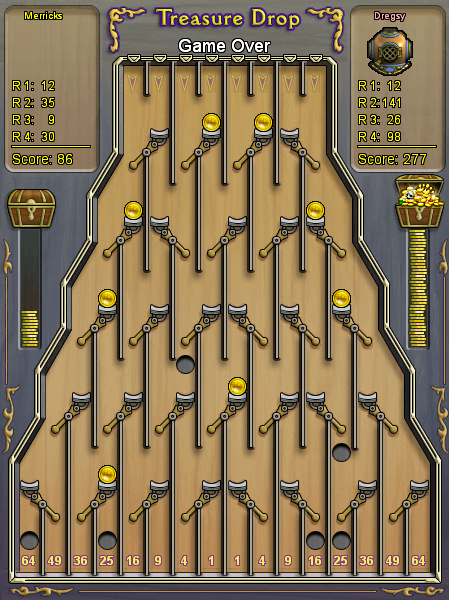



In [ ]:
import numpy as np
from collections import defaultdict
from collections import Counter

In [52]:
class Lever:
    '''Table of treasure drop consists of levers. This class is an abstraction of the levers you see in the image above.'''
    def __init__(self):
        self.position = np.random.randint(low=0, high=2)
        #position is randomly initialized 0 means left and 1 means right.
        
        self.coin = 0
        #this is 1 if a lever has coin. Initially, a lever does not have a coin.
        
        self.leftChild = None  
        self.rightChild = None
        #every lever has either another lever or a bucket to its lower left and lower right.
        #therefore, these variables are either Lever objects or numbers. Numbers represent the score gates at the bottom.
        #if a lever resides in all the way down in the table, its children are numbers.
        
        self.leftMouth = 0
        self.rightMouth = 0
        #This might confuse you. You have to get this right if you want to understand the simulation of the game.
        #If you're only interested in the reinforcement learning, it's okay.
        #left and right mouths mean the top left and top right openings surrounding a lever.
        #these variables denote how many coins are there at a given point in time.
        
    '''printTop, printBottom and printMiddle are helper print methods'''
    def printTop(self):  #prints thetop part of the lever and puts a | character end of it.
        letter = 'V' if self.coin == 0 else 'O'
        if self.position == 0:  #means left
            print(letter + '  |', end="")
        else:
            print('  ' + letter + '|', end="")
    def printMiddle(self):  
        if self.position == 0:
            print(' \ |', end="")
        else:
            print(' / |', end="")
    def printBottom(self):
        if self.position == 0:
            print('  \ ', end="")
        else:
            print('/   ', end="")
            
            
    def spitToLeft(self, i):
        '''This methods lets go i amount of coins to the left of the lever'''
        if self.leftChild == None: #for testing purposes, delete before submisssion
            return 0
        elif type(self.leftChild) == int:  #It's left child is a bucket therefore it's returning a score.
            return i*self.leftChild
        else:
            self.leftChild.rightMouth += i
            return 0
            
    def spitToRight(self, i):
        '''This methods lets go i amount of coins to the right of the lever'''
        if self.rightChild == None: #for testing purposes
            return 0
        if type(self.rightChild) == int:
            return i*self.rightChild
        else:
            self.rightChild.leftMouth += i
            return 0
        
        
    def applyMotion(self):
        '''Applies one timeframe of motion to the lever.'''
        
        score = 0
        if self.coin == 1:  #CASE 1: Lever has a coin.
            temp = self.leftMouth + self.rightMouth
            self.leftMouth = 0 
            self.rightMouth = 0
            if self.position == 0:  #O--
                score += self.spitToRight(temp)
                self.leftMouth = 1
                self.coin = 0 #coin airborne
            else:
                score += self.spitToLeft(temp)
                self.rightMouth = 1
                self.coin = 0 #coin airborne
                
            if temp % 2 == 1:  #sum of coins is odd. Let's flip the lever
                self.position = 0 if self.position == 1 else 1
            
        elif self.coin == 0:  #CASE 2, 3 and 4: Lever does not have a coin.
            #Here, the order of if statements are important. Do not change the order.
            if self.leftMouth != 0 and self.rightMouth != 0 : #CASE 4
                temp = self.leftMouth + self.rightMouth - 1
                self.leftMouth = 0
                self.rightMouth = 0
                
                if self.position == 0:  #U--
                    score += self.spitToRight(temp)
                    self.leftMouth = 1  #coin airborne
                else:  #--U
                    score += self.spitToLeft(temp)
                    self.rightMouth = 1  #coin airborne
                    
                if temp % 2 == 1:  #sum of coins is odd. Let's flip the lever.
                    self.position = 0 if self.position == 1 else 1
                    
            elif (self.leftMouth != 0 and self.position == 0) or (self.rightMouth != 0 and self.position == 1):
                #CASE 2: Coin only arrives on top of empty slot.
                
                temp = self.leftMouth + self.rightMouth
                self.leftMouth = 0
                self.rightMouth = 0
                self.coin = 1
                temp -= 1
                
                if temp>0:  #Apparently, more than one coin arrived to the empty slot.
                    if self.position == 0:  #U--
                        score += self.spitToRight(temp)
                        self.leftMouth = 1  #coin airborne
                        self.coin = 0
                    else:  #--U
                        score += self.spitToLeft(temp)
                        self.rightMouth = 1  #coin airborne
                        self.coin = 0
                        
                if temp % 2 == 1:
                    self.position = 0 if self.position == 1 else 1
                    
            elif (self.leftMouth != 0 and self.position == 1) or (self.rightMouth != 0 and self.position == 0):
                #CASE 3: Coin only arrives to the non-slot side of lever.
                
                temp = self.leftMouth + self.rightMouth
                self.leftMouth = 0
                self.rightMouth = 0
                
                if self.position == 0:  #U--
                    score += self.spitToRight(temp)
                else:  #--U
                    score += self.spitToLeft(temp)
                    
                if temp % 2 == 1:
                    self.position = 0 if self.position == 1 else 1
                    
        return score

In [6]:
def fib(n):
    '''Returns one fibonacci number.'''
    if n==1: 
        return 1
    elif n==2: 
        return 2
    else: 
        return fib(n-1)+fib(n-2)

def fibonacciBuckets(length):
    '''given length, returns fibonacci buckets. Such as, for 4: 5|3|2|1|1|2|3|5'''
    '''this games scores are determined by fibonacci sequence'''
    buckets = [fib(n+1) for n in range(length)]
    bucketsR = buckets.copy()
    bucketsR.reverse()
    return bucketsR+buckets

In [7]:
# w is for width and h is for height.
class TreasureDrop:
    '''Game class'''
    def __init__(self, w=4, h=5, player=1, goalScore = 100):
        
        if player != 1 and player != 2:  #player is who goes first here.
            raise(Exception("Starting player can be 1 or 2, 1 by default."))
        self.player = player  #self.player means whose turn is it. it can be 1 or 2
        self.winner = None  #who is the winner?
        self.isOver = False  #is the game over?
        self.p1score = 0
        self.p2score = 0
        self.goalScore = goalScore  #whenever p1score or p2score goes above goalScore, game ends.
        self.w = w  #width of the top of the board
        self.h = h  #height of the board
        self.buckets = fibonacciBuckets(w+self.h-1)  #score buckets
        self.levers = [[Lever() for n in range(w+i)] for i in range(self.h)]
        
        
        #Setting the lever hierarchy, connecting them to one another.
        #each lever has leftChild and rightChild.
        #these children are either another level or score bucket.
        #levers at the very bottom have score levers as their children
        #others have levers as their children
    
        for rowIndex in range(len(self.levers)):
            for colIndex in range(len(self.levers[rowIndex])):
                if rowIndex < len(self.levers)-1:  #Not the last row of levers
                    self.levers[rowIndex][colIndex].leftChild = self.levers[rowIndex+1][colIndex]
                    self.levers[rowIndex][colIndex].rightChild = self.levers[rowIndex+1][colIndex+1]
                else:  #The last row of levers, buckets should be their children.
                    self.levers[rowIndex][colIndex].leftChild = self.buckets[colIndex*2]
                    self.levers[rowIndex][colIndex].rightChild = self.buckets[colIndex*2+1]
        
    def dropCoin(self, loc, verbose=False):
        '''drops a coin in the specified location of the board.'''
        
        if self.winner:  #Exception if game already ended or invalid location for coin
            raise(Exception("There is a winner. Can't play anymore."))
        elif loc >= self.w*2:  #Checks if location is valid for the coin. It must be.
            raise(Exception("Invalid loc for coin"))
            
        #Put the coin in proper mouth of the proper lever.
        #Each lever has two mouths, left and right
        #When a coin is sitting on the mouth, it is physically moved in the next time frame.
        
        colIndex = loc//2
        if loc%2 == 0:  #give it to left mouth
            self.levers[0][colIndex].leftMouth = 1
        elif loc%2 == 1:  #give it to right mouth
            self.levers[0][colIndex].rightMouth = 1
        
        
        #Simulating physical movement of the board, moving levers and coins.
        #Loop through levers until all mouths are empty.
        #When all mouths of all levers are empty, it means that no physical movement need to happen.
        #Giving every lever a timestep to move.
        #Also, collecting the score at the same time.
        
        allMouthsAreEmpty = False
        score = 0
        while not allMouthsAreEmpty:  #Update should be from bottom rows all the way up, because coins are going down.
            allMouthsAreEmpty = True
            for r in range(len(self.levers)-1, -1, -1):  #Going through levers in a reverse order.
                for i, l in enumerate(self.levers[r]):  #Enumerating for debugging purposes.
                    if l.leftMouth != 0 or l.rightMouth != 0:
                        allMouthsAreEmpty = False
                        score += l.applyMotion()
        
        #Animation simulated. Let's reap the results.
        
        #Give score to player
        if self.player == 1:
            self.p1score += score
        elif self.player == 2:
            self.p2score += score
        
        #It's other player's turn
        if self.player == 1:
            self.player = 2
        elif self.player == 2:
            self.player = 1
        
        #Check if the game ends
        if self.p1score >= self.goalScore:
            self.player = None
            self.winner = 1
            self.isOver = True
        elif self.p2score >= self.goalScore:
            self.player = None
            self.winner = 2
            self.isOver = True
            
        #If verbose, print the game state. OR, you can do this job somewhere else. I'm not sure.
        if verbose:
            self.printState()
            
        return score
        
    
    def printRowOfLevers(self, rowIndex):  
        '''Helper function of printState. Prints one row of levers, given rowIndex'''
        
        #Print 1st line
        print(" " * (self.h-rowIndex)*2 + '|', end="")
        for lever in self.levers[rowIndex]:
            lever.printTop()
        print("")  #Jump to new line
        
        #Print 2nd line
        print(" " * (self.h-rowIndex)*2 + '|', end="")
        for lever in self.levers[rowIndex]:
            lever.printMiddle()
        print("")  #Jump to new line
        
        #Print 3rd line
        leftBottomEdge = " |" if rowIndex == self.h-1 else "/ "
        rightBottomEdge = "\b|" if rowIndex == self.h-1 else "\\"
        print(" " * ((self.h-rowIndex)*2-1) + leftBottomEdge, end="")
        for lever in self.levers[rowIndex]:
            lever.printBottom()
        print(rightBottomEdge)
        
    def printState(self):
        '''Prints the whole board.'''
        
        #Print score line
        print("Player 1                 Player 2")
        print("%s\t\t\t\t%s" % (self.p1score, self.p2score))
        #Print TURN/WINNER line
        if self.winner:
            if self.winner == 1:
                print("WINNER                           ")
            elif self.winner == 2:
                print("                           WINNER")
        else:
            if self.player == 1:
                print("TURN                             ")
            elif self.player == 2:
                print("                             TURN")
        #Print the available moves row
        print(' '*self.h*2+"|", end="")
        for i in range(self.w*2):
            print(str(i)+"|", end="")
        print()
        #Print enterance row
        print(' '*self.h*2 + "|" + " |"*self.w*2)
        #Print intermediary rows
        for idx, _ in enumerate(self.levers):
            self.printRowOfLevers(idx)
        #Print exit row
        print('  ', end="")
        print("|" + " |"*(self.w+self.h-1)*2)
        #Print buckets
        print("  |", end="")
        for b in self.buckets:
            numberToPrint = b//10
            characterToPrint = " " if numberToPrint == 0 else str(numberToPrint)
            print(characterToPrint+"|", end="")
        print()  #In order to move on to the next line
        print("  |", end="")
        for b in self.buckets:
            print(str(b%10)+"|", end="")
        print()
        print()
    
    def getState(self):
        '''For debugging and tabular Q-learning. observe() is for deep q learning. '''
        state = []
        for r in range(len(self.levers)):
            for l in self.levers[r]:
                state.append(l.position)  #position
                state.append(l.coin)  #then coin, represents a state of a lever. Such as: 01
        return state, self.w, self.h
    
    def setState(self, state, w, h):  #adjust the states of levers according to the given state
        '''Sets the state of the game. This is also for debugging and tabular Q-learning. This doesnt set player and score.'''
        if self.w != w or self.h != h:
            print(self.w)
            print(w)
            print(self.h)
            print(h)
            raise(Exception("width and height not compatible for setState()."))
        
        s = state.copy()
        for r in range(len(self.levers)):
            for l in self.levers[r]:
                l.position = s.pop(0)
                l.coin = s.pop(0)
                
    def observe(self):
        '''Observes state, returns a state that goes right into keras model.'''
        return np.asarray(self.getState()[0]).reshape(1, -1)
    
    def nextStates(self):  #returns next states and rewards while getting to them.
        '''returns list of next states and rewards obtained while getting to them.'''
        currentState = self.getState()  #preserving the current state
        nextStatesAndRewards = []
        for i in range(self.w*2):
            td = TreasureDrop(w=self.w, h=self.h)
            td.setState(currentState[0], self.w, self.h)
            reward = td.dropCoin(i, verbose=False)
            nextState = td.getState()
            nextStatesAndRewards.append((nextState[0], reward))  #because nextState[1] is width and nextState[2] is height
        return nextStatesAndRewards
    
    def playable(self):
        return not self.isOver
    
    def leverCount(self):
        '''Number of levers'''
        return int((self.w*self.h) + (self.h-1)*self.h/2)
    
    def numActions(self):
        '''Number of possible actions'''
        return self.w*2
            

## Experience Replay

In [9]:
class ExperienceReplay():
    '''Experience Replay Method'''
    def __init__(self, max_memory=100, alpha=0.000001, gamma=.4):
        self.max_memory = max_memory
        self.alpha = alpha
        self.discount = gamma
        self.memory = list()
        
    def remember(self, sarsars):
        '''Remembers a given (sarsars) sequence.'''
        self.memory.append(sarsars)
        if len(self.memory) > self.max_memory:
            del self.memory[0]
            
    def getBatch(self, model, batchSize):
        '''Gets a batch of inputs and targets. You pass those inputs and targets straight to the keras model.'''
        len_memory = len(self.memory)
        inputSize = model.layers[0].input_shape[-1]  #60 by default game
        outputSize = model.layers[-1].output_shape[-1]  #8 by default game
        #print them here. make sure they are what you want.

        inputs = np.zeros((min(len_memory, batchSize), inputSize))
        targets = np.zeros((len(inputs), outputSize))
        #print inputs and targets here. Make sure they are what you want.
        
        #randomly sample memory, get sarsars pairs
        
        for i, idx in enumerate(np.random.randint(0, len_memory, size=inputs.shape[0])):
            
            s1, a1, r1, s2, a2, r2, s3 = self.memory[idx]
            
            inputs[i:i+1] = s1
            targets[i] = model.predict(s1)[0]
            
            discountedMaxValueOfs3 = np.argmax(model.predict(s3))
            td_target = r1-r2+discountedMaxValueOfs3
            
            td_error = td_target-targets[i, a1]
            targets[i, a1] = self.alpha * td_error

        return inputs, targets
        
        #you have to return an input and output for a deep learning model.
        #s1 is the input
        #the output will be target
        #every output value except the one corresponding to a1 is going to be equal to what the model already predicted.
        #you will construct this for all inputs and targets
        #the you will return inputs and targets.
        

# Set up the game

In [54]:
#Initialize game here. Keras Model cell below will use these values.
td = TreasureDrop(2, 2)  #put width and height of the game board here.
td.w, td.h
td.printState()

Player 1                 Player 2
0				0
TURN                             
    |0|1|2|3|
    | | | | |
    |  V|V  |
    | / | \ |
   / /     \ \
  |V  |  V|V  |
  | \ | / | \ |
  |  \ /     \ |
  | | | | | | |
  | | | | | | |
  |3|2|1|1|2|3|



# Compiling A Keras Model

In [55]:
# Keras model
from keras.models import Sequential
from keras.layers.core import Dense

env_dim = td.leverCount() * 2
num_actions = td.numActions()

model = Sequential()

# Input and first hidden layer
model.add(Dense(units=(env_dim+num_actions)+15//2,  # Rough rule of thumb is mean of input and output number
                input_shape=(env_dim,), 
                activation='relu'))

# Output layer
model.add(Dense(output_dim=num_actions,
          activation='softmax')) 


model.compile(optimizer='adam', 
              loss="categorical_crossentropy")

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 21)                231       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 88        
Total params: 319
Trainable params: 319
Non-trainable params: 0
_________________________________________________________________


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=4)`


# Playing with Random Agent

In [14]:
#play with a random agent e times, collect scores
def playWithRandomAgent(model, w, h, num_episodes=100):  #w, h are width and height of the board
    '''Plays with an agent that acts randomly, returns stats.'''
    winners = []
    p1scores = []
    p2scores = []
    for e in range(num_episodes):
        td = TreasureDrop(w, h)
        
        while not td.isOver:
            #Model plays
            s1 = td.observe()
            a1 = np.argmax(model.predict(s1)[0])
            r1 = td.dropCoin(a1)

            if (td.isOver):
                continue  #game ended

            #Random agent plays
            a2 = np.random.randint(td.numActions())
            r2 = td.dropCoin(a2)
        
        #Collecting game data
        winners.append(td.winner)
        p1scores.append(td.p1score)
        p2scores.append(td.p2score)
    
    modelWinRatio = Counter(winners)[1]/len(winners)  #Model's winning ratio
    modelAvgScore = sum(p1scores)/len(p1scores)
    randomAvgScore = sum(p2scores)/len(p2scores)
    
    return modelWinRatio, modelAvgScore, randomAvgScore
        
#Play a couple times and print the result.
for i in range(10):
    
    modelWinRatio, modelAvgScore, randomAvgScore = playWithRandomAgent(model, td.w, td.h)
    print("Model's win ratio: {} Model's avg score: {} Random Agent's avg score: {}".format(modelWinRatio, modelAvgScore, randomAvgScore))

Model's win ratio: 0.07 Model's avg score: 66.28 Random Agent's avg score: 100.82
Model's win ratio: 0.08 Model's avg score: 67.51 Random Agent's avg score: 101.09
Model's win ratio: 0.04 Model's avg score: 67.21 Random Agent's avg score: 101.62
Model's win ratio: 0.02 Model's avg score: 61.39 Random Agent's avg score: 101.81
Model's win ratio: 0.02 Model's avg score: 62.29 Random Agent's avg score: 101.88
Model's win ratio: 0.09 Model's avg score: 67.26 Random Agent's avg score: 100.49
Model's win ratio: 0.04 Model's avg score: 65.1 Random Agent's avg score: 101.27
Model's win ratio: 0.04 Model's avg score: 62.44 Random Agent's avg score: 100.99
Model's win ratio: 0.05 Model's avg score: 64.34 Random Agent's avg score: 101.3
Model's win ratio: 0.02 Model's avg score: 62.11 Random Agent's avg score: 101.6


# Train Loop

In [32]:
batchSize = 10
num_episodes = 6000
epsilon = .1
experienceReplay = ExperienceReplay()
loss_history = []
width = td.w
height = td.h

#THE TRAINING LOOP

for e in range(num_episodes):
    td = TreasureDrop(width, height)
    totalLoss = 0
    total = 0
    
    while not td.isOver:
        #get current state s1
        s1 = td.observe()
        
        #get action a1
        if np.random.rand() < epsilon:  #random action
            a1 = np.random.randint(td.numActions())
        else:  #greedy action
            a1 = np.argmax(model.predict(s1)[0])
            
        #act on a1, get new state and reward, r1, s2
        r1 = td.dropCoin(a1)
        s2 = td.observe()
        
        if (td.isOver):
            continue
        
        #get action for enemy, a2
        if np.random.rand() < epsilon:  #random action
            a2 = np.random.randint(td.numActions())
        else:  #greedy action
            a2 = np.argmax(model.predict(s2)[0])
            
        #act on a2, get new state and reward, r2, s3
        r2 = td.dropCoin(a2)
        s3 = td.observe()
        
        #put together s1, a1, r1, s2, a2, r2, s3
        sarsars = (s1, a1, r1, s2, a2, r2, s3)
        
        #remember that
        experienceReplay.remember(sarsars)
        
        #sample a batch from experience replay
        inputs, targets = experienceReplay.getBatch(model, batchSize)
        
        #train model on that batch
        loss = model.train_on_batch(inputs, targets)
        
        #record loss
        total += len(targets)
        totalLoss = loss * len(targets)
        
    if e % 100 == 0:  #if episode is divisible by 100:
        #play with a random agent 10 times, see who wins. also collect avg scores, print it.
        modelWinRatio, modelAvgScore, randomAvgScore = playWithRandomAgent(model, td.w, td.h)
        print("Epoch: {} Model's win ratio: {} Model's avg score: {} Random Agent's avg score: {}".format(e, modelWinRatio, modelAvgScore, randomAvgScore))
        
    #print("Episode {} Loss: {}".format(e, totalLoss/total))  #Printing individual loss doesnt make sense for RL.
    loss_history.append(totalLoss/total)
        

Epoch: 0 Model's win ratio: 0.07 Model's avg score: 66.11 Random Agent's avg score: 100.97
Epoch: 100 Model's win ratio: 0.05 Model's avg score: 64.44 Random Agent's avg score: 101.58
Epoch: 200 Model's win ratio: 0.05 Model's avg score: 64.44 Random Agent's avg score: 101.43


KeyboardInterrupt: 

# Plotting Loss Function

In [ ]:
# Setup plotting
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('always')

palette = "Dark2"
%matplotlib inline

# Plot raw loss history
plt.plot(loss_history);

In [ ]:
cumsum, moving_aves = [0], []
N = 100 # Smoothing window; Bigger is more smoothing

for i, x in enumerate(loss_history, 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
        moving_aves.append(moving_ave)

    plt.plot(moving_aves)


# Play against Learned Agent

In [ ]:
#Demo game
td = TreasureDrop(w=2, h=2)

while not td.isOver:
    state = td.observe()
    preds = model.predict(state)[0]
    action = np.argmin(preds)
    td.dropCoin(action, verbose=True)
    reply = input("Make a move: ")
    if reply == "q": 
        break
    move = int(reply)
    td.dropCoin(move, verbose=True)

Player 1                 Player 2
0				0
                             TURN
    |0|1|2|3|
    | | | | |
    |O  |V  |
    | \ | \ |
   /   \   \ \
  |  V|  V|  V|
  | / | / | / |
  |/   /   /  |
  | | | | | | |
  | | | | | | |
  |3|2|1|1|2|3|

Make a move: 0
Player 1                 Player 2
0				1
TURN                             
    |0|1|2|3|
    | | | | |
    |V  |V  |
    | \ | \ |
   /   \   \ \
  |  O|V  |  V|
  | / | \ | / |
  |/     \ /  |
  | | | | | | |
  | | | | | | |
  |3|2|1|1|2|3|

Player 1                 Player 2
0				1
                             TURN
    |0|1|2|3|
    | | | | |
    |O  |V  |
    | \ | \ |
   /   \   \ \
  |  O|V  |  V|
  | / | \ | / |
  |/     \ /  |
  | | | | | | |
  | | | | | | |
  |3|2|1|1|2|3|

Make a move: 0
Player 1                 Player 2
0				6
TURN                             
    |0|1|2|3|
    | | | | |
    |V  |V  |
    | \ | \ |
   /   \   \ \
  |  V|O  |  V|
  | / | \ | / |
  |/     \ /  |
  | | | | | | |
  | | | | | | |
  |3|2|1|1|2|3|

# Cited Codes

Keras Model and Experience Replay code is from Brian Spiering's Reinforcement Learning Course:
https://github.com/brianspiering/rl-course/tree/master/labs/lab_5_catch